### Import Libraries and Modules

In [1]:
import os
import numpy as np
import json
import pickle 
from datetime import datetime as dt

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import DatasetDict

2024-03-16 13:36:26.908557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:36:26.908609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:36:26.909446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:36:26.915700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 13:36:27.784006: W tensorflow/compiler/tf2

In [2]:
from training_utils import load_data, read_entity_dict, spacy_to_biobert_input, align_predictions, compute_ner_metrics

2024-03-16 13:36:28.819134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-16 13:36:28.855522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-16 13:36:28.859232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Constants
*Defining constants upfront for easy configuration and maintenance.*

In [3]:
DATA_PATH = '/data/02_training_data/'
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.2"
MAX_LENGTH = 512
OUTPUT_DIR = '/data/03_models/finetuned/biobert/temp_' + dt.now().strftime('%d%m%Y_%H-%M-%S')

## Data
### Load Datasets

In [4]:
try:
    train = load_data(os.path.join(DATA_PATH,'temp_train_NER.pickle'))
    test = load_data(os.path.join(DATA_PATH,'temp_test_NER.pickle'))
except FileNotFoundError as e:
    print(e)

## Data Preparation

### Load Label Mappings

In [5]:
# Loading label_to_id from a JSON file
with open(os.path.join(DATA_PATH, 'label_to_id.json'), 'r') as file:
    label_to_id = json.load(file)

# Loading id_to_label from a JSON file
with open(os.path.join(DATA_PATH, 'id_to_label.json'), 'r') as file:
    id_to_label = json.load(file)
id_to_label = {int(k): v for k, v in id_to_label.items()}

In [6]:
print(f'Label-to-ID Mapping: {label_to_id}')
print()
print(f'ID-to-Label Mapping: {id_to_label}')

Label-to-ID Mapping: {'O': 0, 'B-SRNA': 1, 'I-SRNA': 2, 'B-TARGETGENE': 3, 'I-TARGETGENE': 4}

ID-to-Label Mapping: {0: 'O', 1: 'B-SRNA', 2: 'I-SRNA', 3: 'B-TARGETGENE', 4: 'I-TARGETGENE'}


In [7]:
id_to_label

{0: 'O', 1: 'B-SRNA', 2: 'I-SRNA', 3: 'B-TARGETGENE', 4: 'I-TARGETGENE'}

### Load Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Convert SpaCy Docs to BioBERT Input Format

In [9]:
train_data_biobert = spacy_to_biobert_input(train, tokenizer, label_to_id)
test_data_biobert = spacy_to_biobert_input(test, tokenizer, label_to_id)
dataset_dict = DatasetDict({
    'train': train_data_biobert,
    'test': test_data_biobert
})

In [10]:
train[0].ents

(micF, ompF)

## Finetune BioBERT

### Training Setup

In [11]:
num_labels = len(label_to_id)

In [12]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

#### Create Output directory

In [15]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    print(f'Output Directory was created: {OUTPUT_DIR}')
else:
    print(f'Output Directory already exists: {OUTPUT_DIR}')

Output Directory was created: /data/03_models/finetuned/biobert/temp_16032024_13-36-29


### Train the Model

In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=10,  
    per_device_train_batch_size=4,
    warmup_steps=10,  
    weight_decay=0.01,  # Regularization
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",  # Save model checkpoint every epoch
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    compute_metrics=None, 
)

# Train the model
trainer.train()

Step,Training Loss
10,1.333000
20,0.593000
30,0.237200
40,0.096800
50,0.033900
60,0.016700


TrainOutput(global_step=60, training_loss=0.3850886245568593, metrics={'train_runtime': 37.5122, 'train_samples_per_second': 6.398, 'train_steps_per_second': 1.599, 'total_flos': 62712922521600.0, 'train_loss': 0.3850886245568593, 'epoch': 10.0})

### Save finetuned model weights

In [17]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

('/data/03_models/finetuned/biobert/temp_16032024_13-36-29/tokenizer_config.json',
 '/data/03_models/finetuned/biobert/temp_16032024_13-36-29/special_tokens_map.json',
 '/data/03_models/finetuned/biobert/temp_16032024_13-36-29/vocab.txt',
 '/data/03_models/finetuned/biobert/temp_16032024_13-36-29/added_tokens.json',
 '/data/03_models/finetuned/biobert/temp_16032024_13-36-29/tokenizer.json')

## Evaluate on Testset

In [51]:
# Use the Trainer to get predictions on the test dataset
predictions, labels, _ = trainer.predict(dataset_dict['test'])
# Convert predictions and labels
preds_list, labels_list = align_predictions(predictions, labels, id_to_label)

# Flatten the predictions and true labels
flat_preds = [item for sublist in preds_list for item in sublist]
flat_true_labels = [item for sublist in labels_list for item in sublist]

PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  B-SRNA
LABEL:  B-SRNA
PRED:  I-SRNA
LABEL:  I-SRNA
PRED:  I-SRNA
LABEL:  I-SRNA
PRED:  O
LABEL:  O
PRED:  B-SRNA
LABEL:  B-SRNA
PRED:  I-SRNA
LABEL:  I-SRNA
PRED:  I-SRNA
LABEL:  I-SRNA
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  B-TARGETGENE
LABEL:  B-TARGETGENE
PRED:  I-TARGETGENE
LABEL:  I-TARGETGENE
PRED:  O
LABEL:  O
PRED:  B-TARGETGENE
LABEL:  B-TARGETGENE
PRED:  I-TARGETGENE
LABEL:  I-TARGETGENE
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  B-SRNA
LABEL:  B-SRNA
PRED:  I-SRNA
LABEL:  I-SRNA
PRED:  I-SRNA
LABEL:  I-SRNA
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:  O
LABEL:  O
PRED:

In [23]:
# Calculate metrics
metrics = compute_ner_metrics(flat_preds, flat_true_labels)
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1-Score:", metrics["f1"])
print("\nClassification Report:\n", metrics["classification_report"])

Precision: 0.8702382842475721
Recall: 0.8784313725490196
F1-Score: 0.8677922541115228

Classification Report:
               precision    recall  f1-score   support

      B-SRNA       0.67      0.32      0.43        19
B-TARGETGENE       0.62      0.64      0.63        25
      I-SRNA       0.84      0.48      0.62        33
I-TARGETGENE       0.72      0.64      0.68        45
           O       0.92      0.98      0.95       388

    accuracy                           0.88       510
   macro avg       0.75      0.61      0.66       510
weighted avg       0.87      0.88      0.87       510



## Plot Confusion Matrix

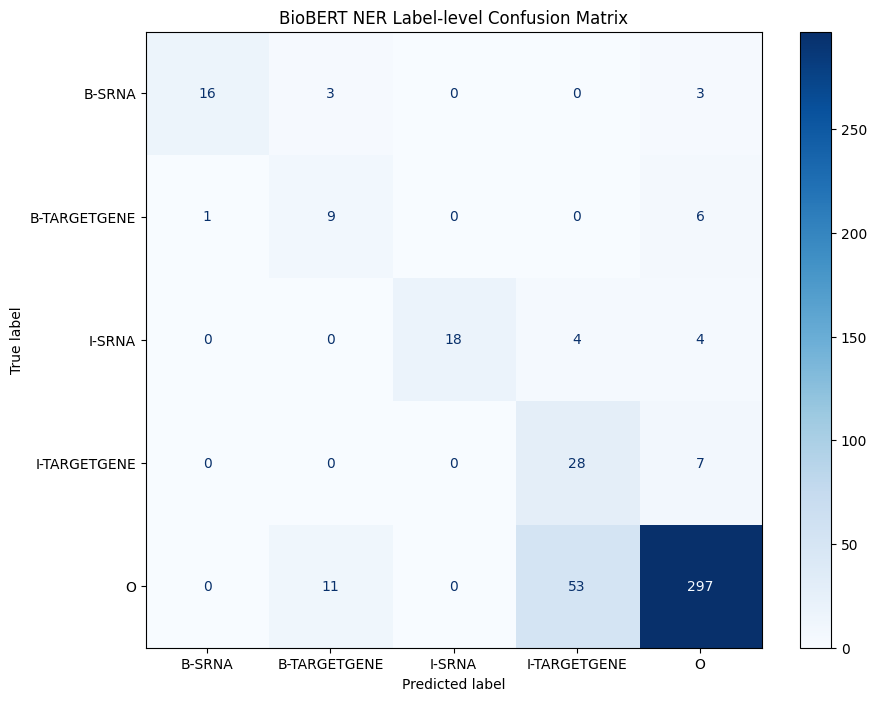

<Figure size 640x480 with 0 Axes>

In [53]:
# Identify unique labels in the true labels
unique_labels = sorted(set(flat_true_labels))

# Calculate the confusion matrix using the unique labels
cm = confusion_matrix(flat_true_labels, flat_preds, labels=unique_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('Predicted Labels')
plt.ylabel('Ground Truth Labels')
plt.title('BioBERT NER Label-level Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()


plt.tight_layout()

In [54]:
cm

array([[ 16,   3,   0,   0,   3],
       [  1,   9,   0,   0,   6],
       [  0,   0,  18,   4,   4],
       [  0,   0,   0,  28,   7],
       [  0,  11,   0,  53, 297]])